In [ ]:
push!(LOAD_PATH, "../functions/")
using BP
using Arpack
using LinearAlgebra
using Random, Plots, SparseArrays, ITensors, Statistics, ProgressMeter, Colors
include("ldpc_tanner_loops.jl")
include("toric_loops.jl")
include("../functions/decoding.jl")
using .ToricLoops

In [2]:
function toric_code_X_parity_matrix(L::Int)
    N = 2 * L^2   # number of qubits
    M = L^2       # number of X checks (vertices)
    
    pcmat = spzeros(Int, M, N)
    
    for v in 1:M
        i = div(v-1, L) + 1  # vertex row
        j = mod1(v, L)       # vertex col
        
        # Horizontal edges (apply periodic boundary for i-1)
        h_edge1 = (mod1(i-1, L) - 1)*L + j
        h_edge2 = (mod1(i, L) - 1)*L + j
        
        # Vertical edges
        v_edge1 = L^2 + (i-1)*L + mod1(j-1, L)
        v_edge2 = L^2 + (i-1)*L + j
        
        pcmat[v, h_edge1] = 1
        pcmat[v, h_edge2] = 1
        pcmat[v, v_edge1] = 1
        pcmat[v, v_edge2] = 1
    end
    
    return pcmat
end

function toric_code_logical_operators(L::Int)
    # Compute the null space (logical operators) of the toric code parity check matrix
    pcmat = toric_code_X_parity_matrix(L)
    N = 2 * L^2
    
    # Convert to GF(2) by using mod 2 arithmetic
    # We'll manually construct the logical operators for the toric code
    
    # For a toric code of size L, there are 2 logical X and 2 logical Z operators
    # We'll return the logical Z operators (null space of X check matrix)
    
    # Create logical operators matrix (2 logical operators)
    logical_ops = zeros(Int, 2, N)
    
    # First logical operator: horizontal loop around the torus
    for i = 1:L
        logical_ops[1, (i-1)*L + 1] = 1  # First column of each row
    end
    
    # Second logical operator: vertical loop around the torus
    for j = 1:L
        logical_ops[2, L^2 + j] = 1  # First row of vertical edges
    end
    
    # Verify these are in the null space (PCM * logical_ops' = 0 mod 2)
    @assert all([(pcmat * logical_ops'[:,i]) .% 2 == zeros(L^2) for i in 1:2])
    
    return logical_ops
end


toric_code_logical_operators (generic function with 1 method)

In [16]:
L = 11
p = 0.03
pbias = p
max_loop_order = 8
pcmat = toric_code_X_parity_matrix(L)
m, n = size(pcmat)
logical_errors = []
logical_ops = toric_code_logical_operators(L);
tannerloopslist = [ToricLoops.find_toric_code_loops(pcmat, d, max_loop_order) for d in 1:n];

In [21]:
# Sample errors iid with probability p
errors_true = [sample_bit(1-p) for _ in 1:n]
# Compute syndrome
syndrome = pcmat * errors_true .% 2;
# tannerloopslist = [find_tanner_loops(pcmat, d; max_length=max_loop_order) for d in 1:n]
err_bits = collect(findall(==(1), errors_true))   
length(err_bits)

10

In [22]:
# Decode
data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors_loops = Int.(-1 .* ones(n))
errors_no_loops = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links;random_part=0.2) 
messages = BP.message_passing(tensors,messages,edges,adj_mat;α=0.5, max_iters=500,diagnose=false,normalise=true);

In [ ]:
# Decode each data qubit
relativenorm = []
selfconsistencyviolation = []

for d = 1:n
    probs = get_marginal(vcat(data_tensors, syn_tensors), adj_mat, messages, d)
    errors_no_loops[d] = tensorargmax(probs)
    push!(selfconsistencyviolation,BP.check_self_consistency(vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors), messages, adj_mat)[2])
    # Get loops for this data qubit
    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_qubits for tannerloop in tannerloops]
    check_bits_involved_list = [[c - n for c in tannerloop.check_qubits] for tannerloop in tannerloops]

    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops; exclude=[d]), syn_tensors)
        
        if !isempty(setdiff(data_bits_involved, [d]))
            normlz1 = scalar(prod([get_marginal(mtensors, adj_mat, messages, other_data_bit) 
                                for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        else
            normlz1 = 1.0
        end
        
        if !isempty(check_bits_involved)
            normlz2 = scalar(prod([get_marginal(mtensors, adj_mat, messages, n+check_bit) 
                                for check_bit in check_bits_involved]))
        else
            normlz2 = 1.0
        end
        
        normlz = normlz1 * normlz2
        if normlz != 0
            change = BP.loop_contribution(loop, messages, mtensors, edges, links, adj_mat) 
            loopprobs += change / normlz
        end
    end
    push!(relativenorm,norm(loopprobs)/norm(probs))
    loopcorr = tensorargmax(probs + loopprobs)  
    errors_loops[d] = loopcorr

    # Early stopping: if both decoders made errors, no point continuing
    if (errors_no_loops[d] != errors_loops[d])  
        println("loop corr happened")
    end 
end

println("syndrome correctness...", (syndrome == pcmat * errors_no_loops .% 2))
println("logical correctness...", logical_ops * (errors_no_loops .+ errors_true .% 2) .% 2)
println("loopcorr syndrome correctness...", (syndrome == pcmat * errors_loops .% 2))
println("loopcorr logical correctness...", logical_ops * (errors_loops .+ errors_true .% 2) .% 2)
println("self consistency violation per sampled bit...", sum(selfconsistencyviolation)/n)
println("relative loop norm per bit...", sum(relativenorm)/n)

 syndrome correctness...false
 logical correctness...[0, 0]
loopcorr syndrome correctness...false
loopcorr logical correctness...[0, 0]
self consistency violation per sampled bit...1.0354053205901244
relative loop norm per bit...0.00022018867414312832


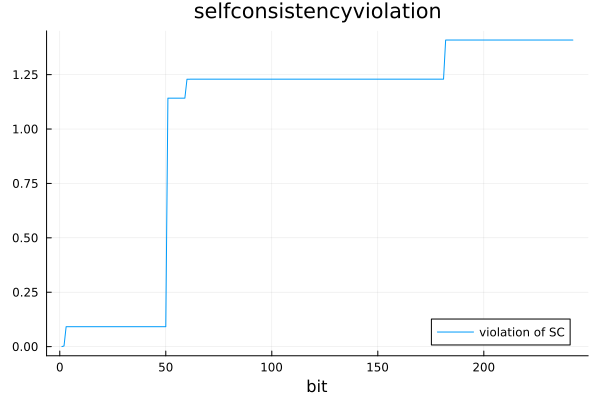

In [24]:
plot(title="selfconsistencyviolation", xlabel="bit")
plot!(1:n, selfconsistencyviolation, label="violation of SC")

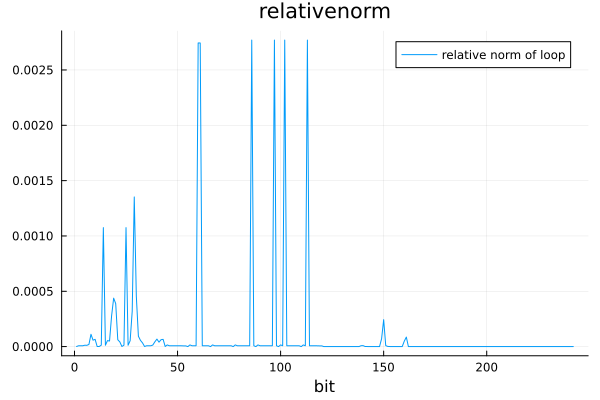

In [54]:
plot(title="relativenorm", xlabel="bit")
plot!(1:n, relativenorm, label="relative norm of loop")
